# Adoption model

We implement the simple adoption model in different versions to examine the role network effects on technology adoption.

## Packages and Options

In [1]:
import sys
sys.path.append("../") # go to parent dir

import pandas as pd
import numpy as np
from applications.adoptionModel import AdoptionModel, Adopter, Technology
import seaborn as sns

## Model setup

Though the model allows for different technologies, we keep it simple by focusing on a single technology:

In [2]:
technologies = [Technology("PV")]

Agents are characterized by:
- adoption_threshold  
  If the adoption score (between zero and one) is above the threshold, the technology is adopted
- network_threshold  
  If the economy wide adoption share is above the threshold the consumer adopts

We create a set of agents with random adoption_thresholds and network_sensitivities assuming that no agent adopted the technology.

In [3]:
num_agents = 1000
bounds_adoption = (0.95, 1)
bounds_network = (0.25, 1)
Adopter._clear()
adopters = [
    Adopter(
        unique_id=i,
        adopted_technologies={t: False for t in technologies},
        adoption_threshold={t: np.random.uniform(*bounds_adoption) for t in technologies},
        network_threshold={t: np.random.uniform(*bounds_network) for t in technologies},
    )
    for i in range(num_agents)
]

Have a look at our agents in terms of threshold and sensitivity

e:\GIT\mesaEconomics\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\GIT\mesaEconomics\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\GIT\mesaEconomics\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\GIT\mesaEconomics\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

(0.25, 1.0)

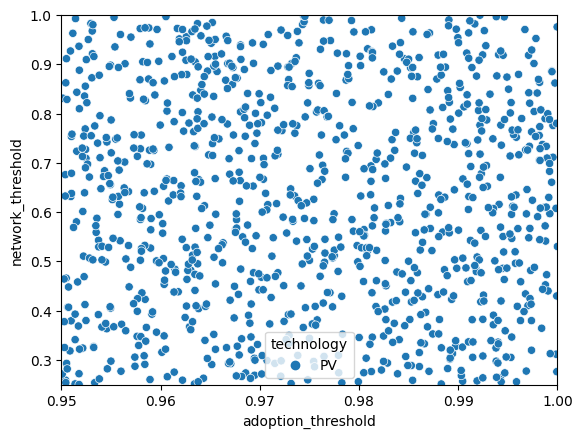

In [4]:
lst_df = []
for t in technologies:
    lst_df.append(
        pd.DataFrame(
            {
                "adoption_threshold": [a.adoption_threshold[t] for a in adopters],
                "network_threshold": [a.network_threshold[t] for a in adopters]
            }
        ).assign(technology=t.unique_id)
    )
df = pd.concat(lst_df)
ax = sns.scatterplot(df, x="adoption_threshold", y="network_threshold", hue="technology")
ax.set_xlim(*bounds_adoption)
ax.set_ylim(*bounds_network)

## Simulations

We perform two simulations: One with and one without the network sensitivity:

In [5]:
num_steps = 100

### With network sensitivity

In [6]:
np.random.seed = 1234
model = AdoptionModel(agents=adopters, commodities=technologies, _seed=1234)
model.reset_randomizer(seed=1234)
for _ in range(num_steps):
    model.step()
df_res = pd.DataFrame(model.datacollector.model_vars["adoption"]).reset_index().assign(scenario="Network")
df_res

,index,PV,scenario
0,0,0.000,Network
1,1,0.020,Network
2,2,0.040,Network
3,3,0.063,Network
4,4,0.084,Network
...,...,...,...
95,95,1.000,Network
96,96,1.000,Network
97,97,1.000,Network
98,98,1.000,Network


## Without network sensitivity

In [7]:
np.random.seed = 1234
for a in adopters:
    for t in a.network_threshold:
        a.network_threshold[t] = 1
        a.adopted_technologies[t] = 0
model = AdoptionModel(agents=adopters, commodities=technologies, _seed=1234)
model.reset_randomizer(seed=1234)
for _ in range(num_steps):
    model.step()
df_res = pd.concat(
    [df_res,
     pd.DataFrame(model.datacollector.model_vars["adoption"]).reset_index().assign(scenario="NoNetwork")
     ]
)

<Axes: xlabel='index'>

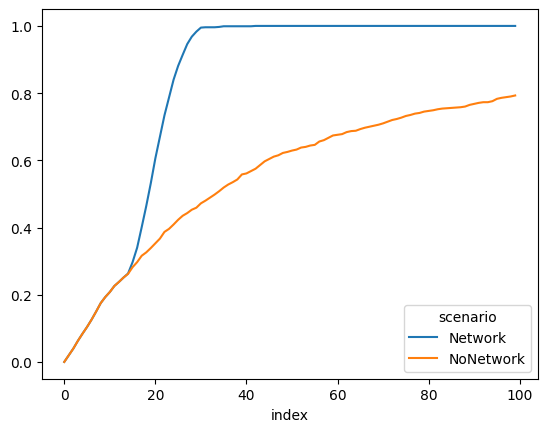

In [8]:
df_res.pivot_table("PV", "index", "scenario").plot()

In [9]:
df_res.pivot_table("PV", "index", "scenario")

scenario,Network,NoNetwork
index,,
0,0.000,0.000
1,0.020,0.020
2,0.040,0.040
3,0.063,0.063
4,0.084,0.084
...,...,...
95,1.000,0.783
96,1.000,0.786
97,1.000,0.788
